In [1]:
import numpy as np                                                                                                                                                                                      
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
from zipfile import ZipFile
import io
import seaborn as sns
import os
import gc
from scipy import integrate
import scipy.signal as sg
import scipy.interpolate as si

import full_expression_PSD as full
import modular_PSD as mod
import extended_PSD as ext

sns.set(style='ticks', palette="Set2")
sns.despine()

sim_dir = '/Users/kcoppess/muspelheim/simulation-results/martin-magmanonlinear/high-res/'
zip_filename = sim_dir + '60__RUPTURE__3000s_1024pts__CHAM_00e6m3__PLUG_02e6Pa_1e-03_pos0750m__MAGMA_cVF80_n001.zip'

save_path = '/Users/kcoppess/Desktop/gestrich/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
save_file = save_path + 'mnl-'

<Figure size 432x288 with 0 Axes>

In [2]:
gTurbColor = '#7678ED'
fTurbColor = '#3D348B'

gImpColor = '#F7B801'
fImpColor = '#F18701'

In [3]:
kk = 1

directory = ZipFile(zip_filename, mode='r')
t1 = np.loadtxt(io.BytesIO(directory.read('time.txt')), delimiter=',')[::kk]
height = np.loadtxt(io.BytesIO(directory.read('height.txt')), delimiter=',')
p1 = np.loadtxt(io.BytesIO(directory.read('pressure.txt')), delimiter=',')[:,::kk]
n1 = np.loadtxt(io.BytesIO(directory.read('massfraction.txt')), delimiter=',')[:,::kk]
u1 = np.loadtxt(io.BytesIO(directory.read('velocity.txt')), delimiter=',')[:,::kk]
rho1 = np.loadtxt(io.BytesIO(directory.read('density.txt')), delimiter=',')[:,::kk]
directory.close()


In [4]:
modulo = 2
dt = 0.04

length = int(25*60 / dt)
t = np.arange(length) * dt

time_smooth = si.interp1d(np.arange(len(t1))[::modulo], t1[::modulo], kind='cubic', fill_value='extrapolate')
times = time_smooth(np.arange(len(t1))[:-modulo])

p_smooth = si.interp1d(times, p1[:, :-modulo], kind='cubic', axis=1, fill_value='extrapolate')
p = p_smooth(t)

n_smooth = si.interp1d(times, n1[:, :-modulo], kind='cubic', axis=1, fill_value='extrapolate')
n = n_smooth(t)

u_smooth = si.interp1d(times, u1[:, :-modulo], kind='cubic', axis=1, fill_value='extrapolate')
u = u_smooth(t)

rho_smooth = si.interp1d(times, rho1[:, :-modulo], kind='cubic', axis=1, fill_value='extrapolate')
rho = rho_smooth(t)

gc.collect()

111

In [5]:
x = (height - (max(height) + 150)*np.ones(len(height)))

phi = 461 * 900 * rho * n / p

rho_g_full = rho * n / phi

gc.collect()

0

In [6]:
shift = int(5/0.04) #int(14 / 0.04)

TT = len(t)
interval = 10 #int(10 / 0.04)
NN = int((TT-shift) / interval) + 1

time_points = t[shift::interval]
time_index = np.arange(TT)[shift::interval]

frag_depths = []
for ii in range(NN):
    frag_depths.append(np.argwhere(phi[:,time_index[ii]] > 0.8)[0,0])

print(len(frag_depths))
print(len(time_points))

3738
3738


In [7]:
frag_depth = min(frag_depths)

depths = -x[frag_depth:]
ll = len(depths)
u_mean = u[frag_depth:, time_index]
phi_p = 1.0 - phi[frag_depth:, time_index]
rho_g = rho_g_full[frag_depth:, time_index]

ch_p = p[0, time_index]

# for ii, DF in zip(np.arange(NN), frag_depths):
#     shift = DF - frag_depth
#     u_mean[:shift, ii] = 0
#     phi_p[:shift, ii] = 0
#     rho_g[:shift, ii] = 0

Dr = 1.4e-3 * np.ones(ll)
Db = 0.5 * np.ones(ll)

In [ ]:
%matplotlib notebook

plt.pcolormesh(time_points, -depths, u_mean)
plt.plot(time_points, x[frag_depths], '.')
plt.ylabel('depth (m)')
plt.xlabel('time (s)')
# plt.ylim(-460, -440)
# plt.xlim(0, 1)
plt.colorbar()
plt.tight_layout()
# plt.savefig('/Users/kcoppess/Desktop/test/vel-dx2m-smoothed.png', dpi=300)
plt.show()

In [ ]:
%matplotlib notebook

labels = []
for gg in time_points:
    labels.append(str(round(gg)) + 's')

ALPHA = 1
# colors = ["#08519c", "#3182bd", "#6baed6", "#bdd7e7"]
# fd_color = '#fcbba1'
# colors = ['#a50f15', '#de2d26', '#fb6a4a', '#fc9272']
fd_color = '#c7e9b4'
colors = ['#253494', '#2c7fb8', '#41b6c4', '#7fcdbb']
line_styles = ['-', ':', '-.', '--']

plt.figure(figsize=(8,4))

plt.subplot(1,3,1)
plt.axvline(0, color='k', linestyle='-', linewidth=1, alpha=1)
for ii in range(NN):
    if ii==0:
        plt.axhline(depths[frag_depths[ii] - frag_depth]*1e-3, linewidth=1.5, color=fd_color, linestyle=line_styles[ii], alpha=ALPHA, label='$d_f$')
    else:
        plt.axhline(depths[frag_depths[ii] - frag_depth]*1e-3, linewidth=1.5, color=fd_color, linestyle=line_styles[ii], alpha=ALPHA)
    plt.plot(u_mean[:,ii], depths*1e-3, color=colors[ii], linewidth=2, linestyle=line_styles[ii], label=labels[ii])
    plt.ylim(depths[0]*1e-3, depths[-1]*1e-3)
plt.xlim(-0.01, np.max(u_mean))
plt.legend(frameon=True)
plt.xlabel('velocity (m/s)')
plt.ylabel('depth (km)')

plt.subplot(1,3,2)
# plt.axvline(0, color='grey', linestyle='--', alpha=0.3)
for ii in range(NN):
    plt.axhline(depths[frag_depths[ii] - frag_depth]*1e-3, linewidth=1.5, color=fd_color, linestyle=line_styles[ii], alpha=ALPHA)
    plt.plot(phi_p[:,ii], depths*1e-3, linewidth=2, color=colors[ii], linestyle=line_styles[ii])
plt.ylim(depths[0]*1e-3, depths[-1]*1e-3)
plt.xlim(0, phi_p[frag_depths[3] - frag_depth,3])
plt.xlabel('particle volume fraction')

plt.subplot(1,3,3)
# plt.axvline(0, color='grey', linestyle='--', linewidth=1, alpha=0.3)
for ii in range(NN):
    plt.axhline(depths[frag_depths[ii] - frag_depth]*1e-3, linewidth=1.5, color=fd_color, linestyle=line_styles[ii], alpha=ALPHA)
    plt.plot(rho_g[:,ii], depths*1e-3, linewidth=2, color=colors[ii], linestyle=line_styles[ii])
plt.xlim(0, rho_g[frag_depths[3] - frag_depth,3])

plt.ylim(depths[0]*1e-3, depths[-1]*1e-3)
plt.xlabel('gas density (kg/m$^3$)')

plt.tight_layout()
# plt.savefig('/Users/kcoppess/Desktop/gestrich/paper-figures/ONSET-largeVOL-vulcanian-inputfields-evolution.png', dpi=300)
plt.show() 

In [8]:
directory = '/Users/kcoppess/muspelheim/synthetic-seismograms/synthetic-seismograms/greens_functions/lesageGeneric3535m_BooreJoyner_conduit/extended_6km_sf/10km/'
f, gf_hat, gf_time = ext.load_gfs_ES(directory, depths, RETURNTIME=True)

In [9]:
FF = len(f)
impacts = np.zeros((NN, FF))
turbulence = np.zeros((NN, FF))

for ii, DF in zip(np.arange(NN), frag_depths):
    shift = DF - frag_depth
    
    imps = ext.impact_PSD_ES_numGF(f, depths, gf_hat, u_mean[:,ii], Dr, phi_p[:,ii], dz=(x[1]-x[0]), R=30)
    impacts[ii] = np.sum(imps[shift:], axis=0)
    
    turb = ext.turbulence_PSD_ES_numGF(f, depths, gf_hat, u_mean[:,ii], Db, rho_g[:,ii], dz=(x[1]-x[0]), R=30)
    turbulence[ii] = np.sum(turb[shift:], axis=0)
    
impacts_dB = 10 * np.log10(impacts)
turbulence_dB = 10 * np.log10(turbulence)

av_impacts_dB = 10 * np.log10(np.average(impacts[:,1:], axis=1))
av_turbulence_dB = 10 * np.log10(np.average(turbulence[:,1:], axis=1))

/Users/kcoppess/muspelheim/gestrich-model/modular_PSD.py:152: RuntimeWarning: divide by zero encountered in power
  Ek = K * epsilon**(2/3) * kt**(-5/3) # eq 18 in Gestrich
/Users/kcoppess/muspelheim/gestrich-model/extended_PSD.py:238: RuntimeWarning: invalid value encountered in multiply
  FGjz2 = F_tilda * (np.sqrt(2) * gfs[0][:,:,0] + gfs[1][:,:,0])**2
/Users/kcoppess/muspelheim/gestrich-model/extended_PSD.py:241: RuntimeWarning: invalid value encountered in multiply
  PSD = 8 * np.pi**3 * R * dz * f_matrix**2 * np.abs(FGjz2)
/var/folders/wj/yrvy2f3s0c1flzxmw9bh3g1r0000gn/T/ipykernel_3578/1812945987.py:14: RuntimeWarning: divide by zero encountered in log10
  impacts_dB = 10 * np.log10(impacts)


In [ ]:
print(turb)

<IPython.core.display.Javascript object>


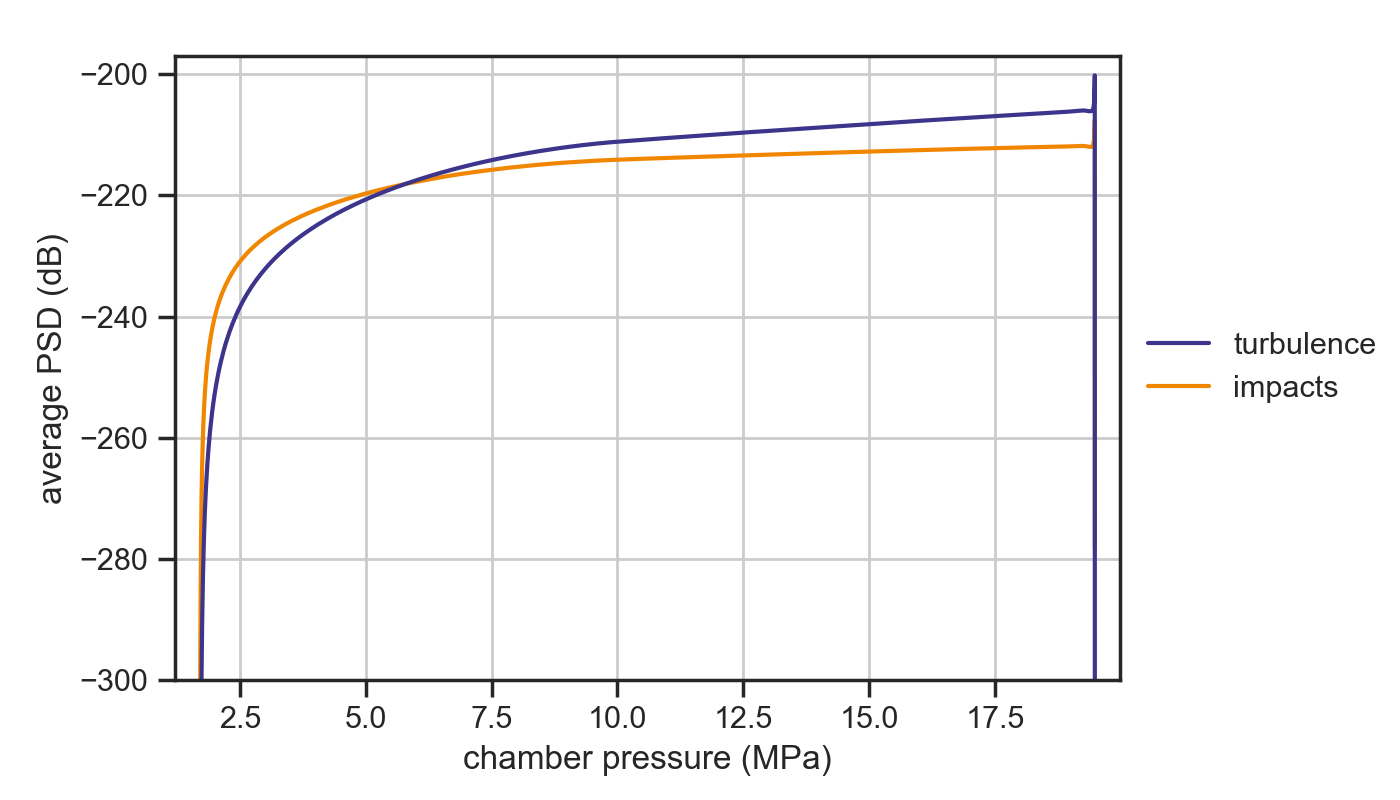

In [17]:
%matplotlib notebook

ax = plt.figure(figsize=(7,4))

legend_elements = [Line2D([0], [0], color=fTurbColor, linestyle='-', label='turbulence'), 
                   Line2D([0], [0], color=fImpColor, linestyle='-', label='impacts')]
leg = plt.legend(handles=legend_elements, frameon=False, fontsize=11, bbox_to_anchor=(1, 0.4), loc='lower left')

# plt.plot(time_points/60, av_impacts_dB, color=fImpColor)
# plt.plot(time_points/60, av_turbulence_dB, color=fTurbColor)

plt.plot(ch_p*1e-6, av_impacts_dB, color=fImpColor)
plt.plot(ch_p*1e-6, av_turbulence_dB, color=fTurbColor)

plt.grid()
plt.subplots_adjust(top=0.93, right=0.8, bottom=0.15)
# plt.ylim(-300, -197)
# plt.xlim(-0.5, 25)
# plt.xlabel('time (min)')

plt.xlim(np.min(ch_p)*1e-6-0.5, np.max(ch_p)*1e-6+0.5)
plt.ylim(-300, -197)
plt.xlabel('chamber pressure (MPa)')

plt.ylabel('average PSD (dB)')

# plt.savefig('/Users/kcoppess/Desktop/gestrich/paper-figures/vulcanian-averagePSD-vs-chamberpressure-everypoint.png', dpi=300)
plt.show()

In [ ]:
%matplotlib notebook

labels = []
for gg in time_points:
    labels.append(str(round(gg)) + 's')

line_styles = ['-', ':', '-.', '--', '.']

ax = plt.figure(figsize=(7,4))

legend_elements = [Line2D([0], [0], color=fTurbColor, linestyle='-', label='turbulence'), 
                   Line2D([0], [0], color=fImpColor, linestyle='-', label='impacts')]
leg = plt.legend(handles=legend_elements, frameon=False, fontsize=11, bbox_to_anchor=(1, 0.6), loc='lower left')

legend_elements1 = [Line2D([0], [0], color='gray', linestyle='-', label=labels[0]), 
                   Line2D([0], [0], color='gray', linestyle=':', label=labels[1]),
                   Line2D([0], [0], color='gray', linestyle='-.', label=labels[2]),
                   Line2D([0], [0], color='gray', linestyle='--', label=labels[3])]
leg1 = plt.legend(handles=legend_elements1, frameon=False, fontsize=11, bbox_to_anchor=(1, 0.2), loc='lower left')

ax.add_artist(leg)

for ii in range(NN):
    plt.plot(f, impacts_dB[ii], color=fImpColor, linestyle=line_styles[ii])#, alpha=(NN-ii)/NN)
    plt.plot(f, turbulence_dB[ii], color=fTurbColor, linestyle=line_styles[ii])#, alpha=(NN-ii)/NN)

plt.grid()
plt.subplots_adjust(top=0.93, right=0.8, bottom=0.15)
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD (dB)')
# plt.yticks(np.arange(-300, -85, 20.0))
plt.xticks(np.arange(0, 6, 1.0))
plt.ylim(-230, -185)
plt.xlim(0.8, 5)
# plt.legend()
# plt.tight_layout()
# plt.savefig('/Users/kcoppess/Desktop/gestrich/paper-figures/largeVOL-vulcanian-PSD-evolution.png', dpi=300)
plt.show()

In [ ]:
%matplotlib notebook

plt.pcolormesh(time_points, f, turbulence_dB.transpose() + impacts_dB.transpose())
plt.ylabel('frequency (Hz)')
plt.xlabel('time (s)')
plt.ylim(0.8, 5)
# plt.xlim(0, 1)
plt.colorbar()
plt.tight_layout()
# plt.savefig('/Users/kcoppess/Desktop/test/vel-dx2m-smoothed.png', dpi=300)
plt.show()